# Large Bubbles Detection with the red ligths

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

Image Shape:  (1216, 1635)
Image min:  5
Image max:  255


Text(0, 0.5, 'Frequency')

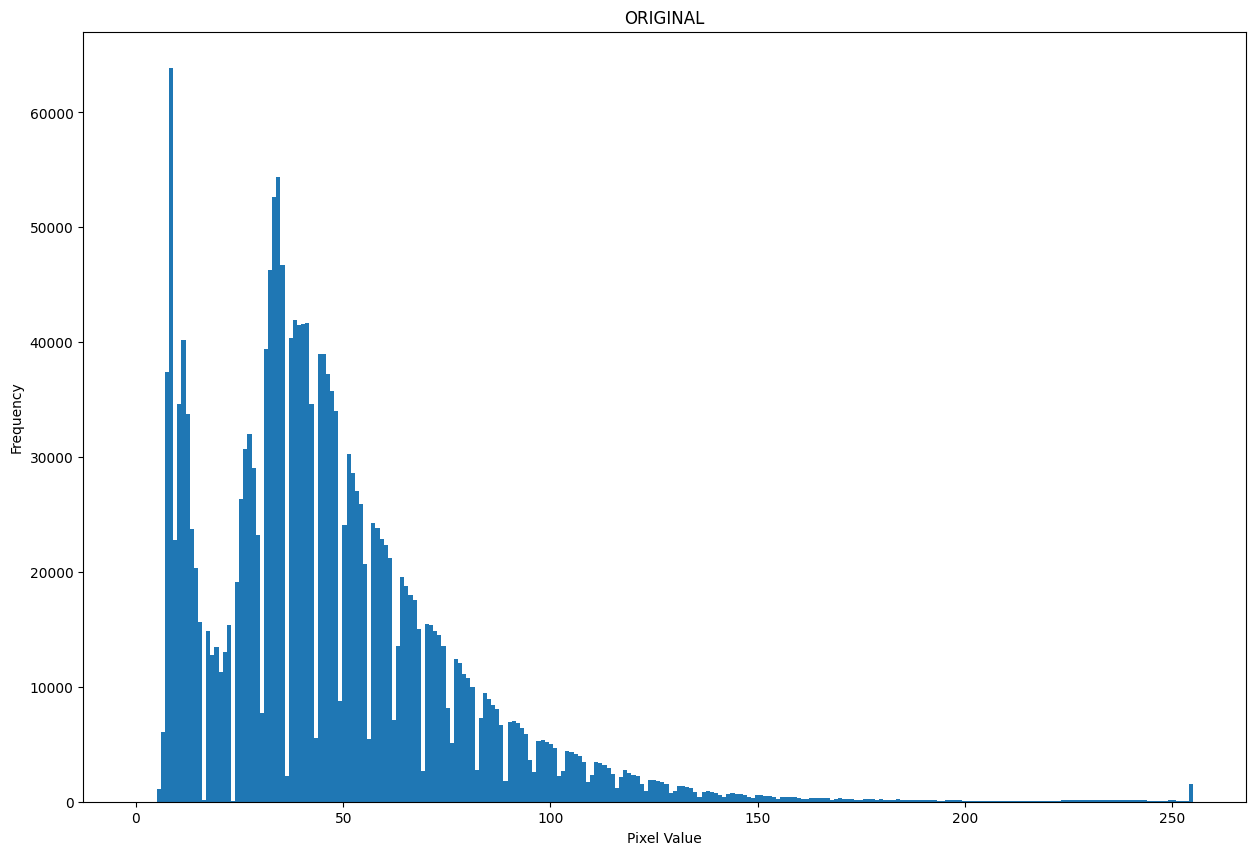

In [2]:
# Get the current working directory
baseFolder = os.getcwd()

# Define the folder containing the images
folder = os.path.join(baseFolder, "FINAL_PHOTOS", "BUBBLES_RED_LIGHT")

# Read the image in grayscale
img = cv.imread(os.path.join(folder, "8.png"))

# Based on the ligth used we read only the red channel
_ , _, r_img = cv.split(img)

print("Image Shape: ", r_img.shape)
print("Image min: ", r_img.min())
print("Image max: ", r_img.max())

img_shown = cv.resize(r_img, (800, 600))

# The image is shown
#cv.imshow('Loaded Image', img_shown) # We show the found corners in the image
#cv.waitKey(1000)
#cv.destroyAllWindows()


# We show the histogram of the image
plt.figure(figsize=(15, 10))
plt.hist(r_img.ravel(), bins=256, range=(0, 255))
plt.title("ORIGINAL")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")

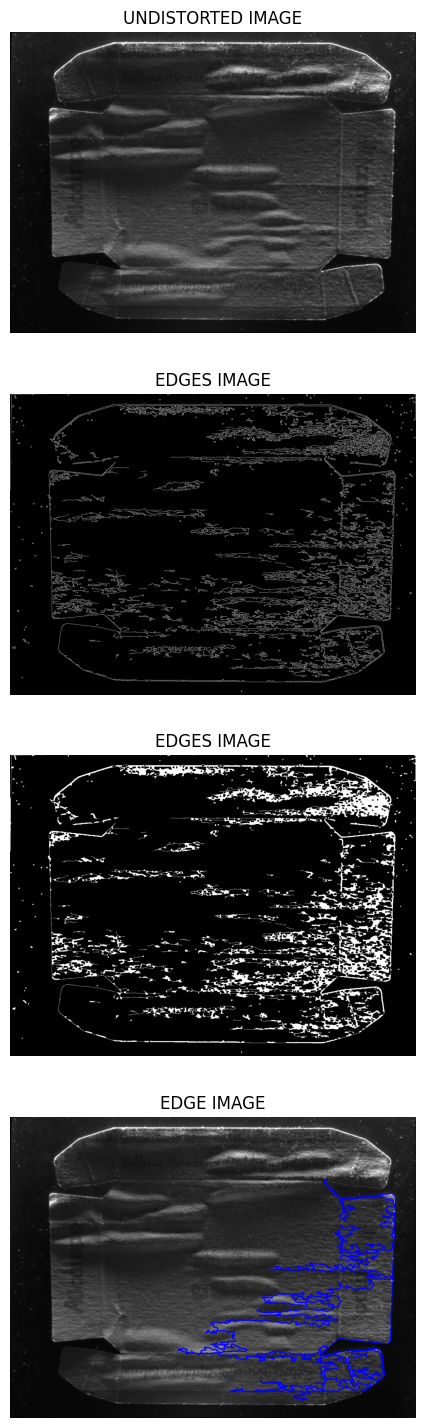

In [3]:
cameraParameters = np.load(baseFolder + "/calibration/camera_lens_12mm.npz")

# We extract the camera matrix and distortion coefficients, through the keys in the dictionary
mtx = cameraParameters['mtx']
dist = cameraParameters['dist']
res = cameraParameters['res']

# We find the dimensions of the image
h, w = r_img.shape[:2]

# We find the new camera matrix and interested region
newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

# We undistort the image
udst_img = cv.undistort(r_img, mtx, dist, None, newcameramtx)

blur = cv.GaussianBlur(udst_img, (5, 5), 0)
edges = cv.Canny(blur, 20, 80, L2gradient=True)
# --- Fin de la sección de prueba ---


# --- PASO CLAVE PARA CERRAR HUECOS ---
# 1. Crear un 'kernel' o elemento estructurante. El tamaño (5,5)
#    define qué tan grandes son los huecos que queremos cerrar.
#    Puedes probar con (3,3) o (7,7) si no funciona bien.
kernel = cv.getStructuringElement(cv.MORPH_RECT, (5, 5))

# 2. Aplicar la operación de Clausura Morfológica (Closing)
closed_edges = cv.morphologyEx(edges, cv.MORPH_CLOSE, kernel)
# ----------------------------------------


# 3. Encontrar contornos EN LA IMAGEN 'CERRADA'
contours, hierarchy = cv.findContours(closed_edges, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)


# 4. Encontrar el contorno con el mayor PERÍMETRO
if len(contours) > 0:
    largest_contour = max(contours, key=lambda c: cv.arcLength(c, True))

    # 5. Preparar la imagen para dibujar en color
    output_image = cv.cvtColor(udst_img, cv.COLOR_GRAY2BGR)

    # 6. Dibujar el contorno más grande en la imagen de salida
    cv.drawContours(output_image, [largest_contour], -1, (0, 0, 255), 3)

    # Mostrar los resultados para comparar
    cv.imshow('Bordes de Canny (con huecos)', edges)
    cv.imshow('Bordes Cerrados (sin huecos)', closed_edges)
    cv.imshow('Contorno mas largo', output_image)
    cv.waitKey(0)
    cv.destroyAllWindows()
else:
    print("No se encontraron contornos.")




plt.figure(figsize=(18,18))
plt.subplot(4,1,1)
plt.imshow(udst_img, cmap='grey')
plt.axis("off")
plt.title("UNDISTORTED IMAGE")
plt.subplot(4,1,2)
plt.imshow(edges, cmap='grey')
plt.axis("off")
plt.title("EDGES IMAGE")
plt.subplot(4,1,3)
plt.imshow(closed_edges, cmap='grey')
plt.axis("off")
plt.title("EDGES IMAGE")
plt.subplot(4,1,4)
plt.imshow(output_image, cmap='grey')
plt.axis("off")
plt.title("EDGE IMAGE")
plt.show()

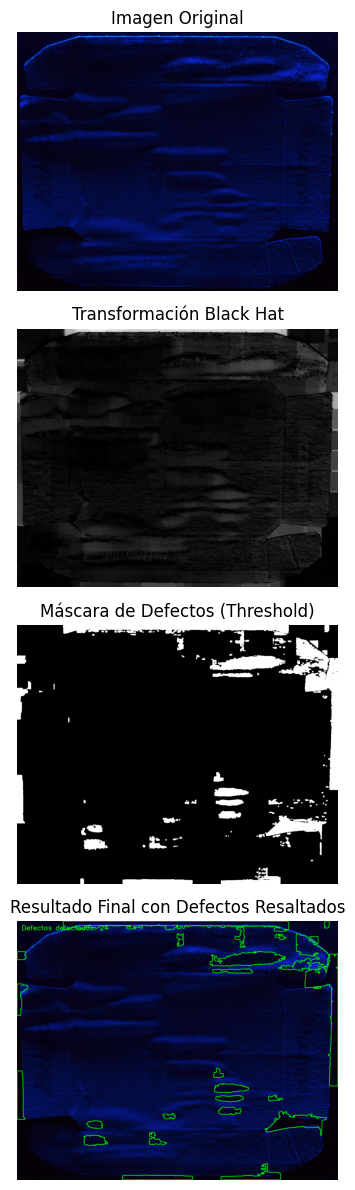

In [4]:
# Get the current working directory
baseFolder = os.getcwd()

# Define the folder containing the images
folder = os.path.join(baseFolder, "FINAL_PHOTOS", "BUBBLES_RED_LIGHT")

# Read the image in grayscale
image = cv.imread(os.path.join(folder, "1_cropped.png"))

if image is None:
    print("No se pudo cargar la imagen. Revisa la ruta.")
else:
    # 2. Preprocessing: Convertir a escala de grises
    # Dado que la imagen es muy rojiza, la conversión a grises
    # conservará bien las variaciones de intensidad.
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

    # Aplicar un ligero desenfoque para suavizar la textura y reducir el ruido
    gray = cv.GaussianBlur(gray, (5, 5), 0)

    # 3. Transformación Morfológica "Black Hat"
    # Esta operación resalta las áreas oscuras en fondos claros.
    # Necesitamos un "kernel" o elemento estructurante. Su tamaño debe ser
    # más grande que los defectos que queremos detectar.
    # Experimenta con este tamaño (ej. 35x35, 45x45) para obtener mejores resultados.
    kernel_size = (75, 75)
    kernel = cv.getStructuringElement(cv.MORPH_RECT, kernel_size)
    
    # Aplicamos la transformación blackhat
    blackhat = cv.morphologyEx(gray, cv.MORPH_BLACKHAT, kernel)

    # 4. Umbralización (Thresholding)
    # Después del blackhat, los defectos son áreas brillantes.
    # Los convertimos a una máscara binaria.
    # El valor 20 es el umbral; ajústalo si es necesario.
    _, thresh = cv.threshold(blackhat, 30, 255, cv.THRESH_BINARY)
    
    # Opcional: Dilatar la máscara para hacer los defectos más sólidos
    thresh = cv.dilate(thresh, None, iterations=2)

    # 5. Encontrar y Filtrar Contornos
    # Buscamos los contornos en la máscara
    contours, _ = cv.findContours(thresh.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    # Preparamos una copia de la imagen original para dibujar los resultados
    output_image = image.copy()
    
    min_defect_area = 500  # Área mínima para ser considerado un defecto (ajústala)
    detected_defects = 0

    for contour in contours:
        # Filtramos por área para eliminar el ruido
        if cv.contourArea(contour) > min_defect_area:
            detected_defects += 1
            # Dibujamos el contorno del defecto en verde sobre la imagen original
            cv.drawContours(output_image, [contour], -1, (0, 255, 0), 2)

    # Añadir texto con el número de defectos detectados
    cv.putText(output_image, f"Defectos detectados: {detected_defects}", (20, 40), 
                cv.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)


    # 6. Mostrar los resultados
    plt.figure(figsize=(20, 12))
    plt.subplot(4, 1, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Imagen Original')
    plt.axis('off')
    plt.subplot(4, 1, 2)
    plt.imshow(blackhat, cmap='gray')
    plt.title('Transformación Black Hat')
    plt.axis('off')
    plt.subplot(4, 1, 3)
    plt.imshow(thresh, cmap='gray')
    plt.title('Máscara de Defectos (Threshold)')
    plt.axis('off')
    plt.subplot(4, 1, 4)
    plt.imshow(output_image, cmap='gray')
    plt.title('Resultado Final con Defectos Resaltados')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

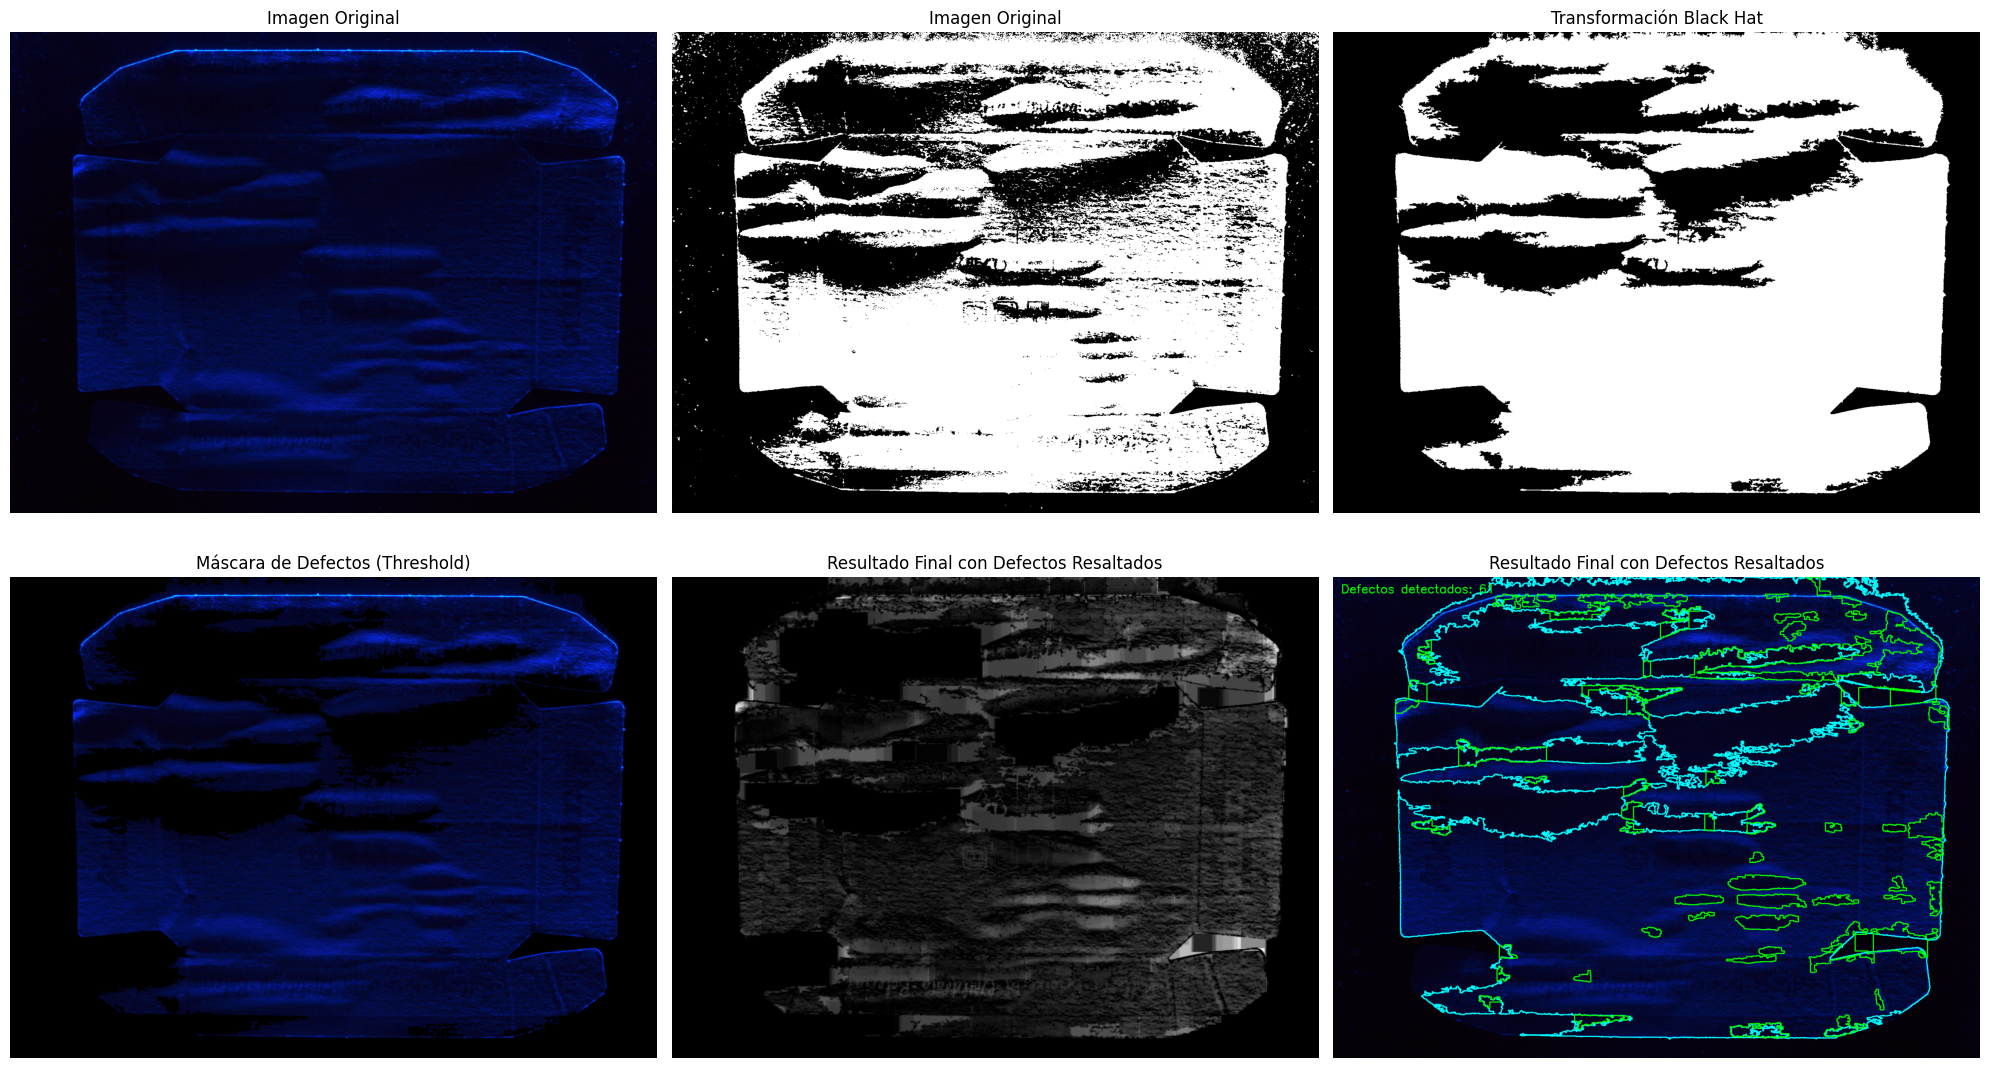

In [11]:
import cv2
import numpy as np

# Cargar la imagen
image = cv2.imread(os.path.join(folder, "8.png"))

if image is None:
    print("No se pudo cargar la imagen. Revisa la ruta.")
else:
    # --- FASE 1: AISLAR LA CAJA (CONTORNO PRINCIPAL) ---

    # Convertir a escala de grises para facilitar la creación de la máscara
    gray_for_mask = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Aplicar un umbral binario. Los píxeles por encima de 20 se vuelven blancos (255).
    # Esto separará fácilmente la caja (brillante) del fondo (oscuro).
    _, binary_mask = cv2.threshold(gray_for_mask, 15, 255, cv2.THRESH_BINARY)

    # Encontrar todos los contornos en la máscara binaria
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Encontrar el contorno más grande por área (esta será la caja)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)

        # Crear una máscara vacía (negra) del mismo tamaño que la imagen
        box_mask = np.zeros_like(gray_for_mask)

        # Dibujar el contorno de la caja relleno de blanco en la máscara
        cv2.drawContours(box_mask, [largest_contour], -1, 255, thickness=cv2.FILLED)

        # Usar la máscara para "recortar" la caja de la imagen original.
        # Esta es nuestra Región de Interés (ROI).
        roi_image = cv2.bitwise_and(image, image, mask=box_mask)

        # --- FASE 2: DETECTAR DEFECTOS DENTRO DE LA CAJA (ROI) ---

        # Convertir nuestra ROI a escala de grises para el análisis de defectos
        gray_defects = cv2.cvtColor(roi_image, cv2.COLOR_BGR2GRAY)
        
        # Aplicar desenfoque para suavizar
        gray_defects = cv2.GaussianBlur(gray_defects, (5, 5), 0)

        # Aplicar la transformación "Black Hat" para resaltar defectos oscuros
        # (Usamos el mismo método que la vez anterior)
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (45, 45))
        blackhat = cv2.morphologyEx(gray_defects, cv2.MORPH_BLACKHAT, kernel)

        # Umbralizar el resultado del blackhat para obtener una máscara de los defectos
        _, thresh_defects = cv2.threshold(blackhat, 20, 255, cv2.THRESH_BINARY)
        
        # Dilatar la máscara para hacer los defectos más sólidos
        thresh_defects = cv2.dilate(thresh_defects, None, iterations=2)

        # Encontrar los contornos de los defectos
        defect_contours, _ = cv2.findContours(thresh_defects, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # --- VISUALIZACIÓN FINAL ---

        # Preparamos una copia de la imagen original para dibujar los resultados
        output_image = image.copy()

        # Opcional: Dibujar el borde de la caja detectada en otro color (ej. amarillo)
        cv2.drawContours(output_image, [largest_contour], -1, (0, 255, 255), 2)

        min_defect_area = 500  # Área mínima para ser considerado un defecto
        detected_defects = 0

        for contour in defect_contours:
            if cv2.contourArea(contour) > min_defect_area:
                detected_defects += 1
                # Dibujar el contorno del defecto en verde
                cv2.drawContours(output_image, [contour], -1, (0, 255, 0), 2)
        
        cv2.putText(output_image, f"Defectos detectados: {detected_defects}", (20, 40), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        
            # 6. Mostrar los resultados
        plt.figure(figsize=(20, 12))
        plt.subplot(2, 3, 1)
        plt.imshow(image, cmap='gray')
        plt.title('Imagen Original')
        plt.axis('off')
        plt.subplot(2, 3, 2)
        plt.imshow(binary_mask, cmap='gray')
        plt.title('Imagen Original')
        plt.axis('off')
        plt.subplot(2, 3, 3)
        plt.imshow(box_mask, cmap='gray')
        plt.title('Transformación Black Hat')
        plt.axis('off')
        plt.subplot(2, 3, 4)
        plt.imshow(roi_image, cmap='gray')
        plt.title('Máscara de Defectos (Threshold)')
        plt.axis('off')
        plt.subplot(2, 3, 5)
        plt.imshow(blackhat, cmap='gray')
        plt.title('Resultado Final con Defectos Resaltados')
        plt.axis('off')
        plt.tight_layout()
        plt.subplot(2, 3, 6)
        plt.imshow(output_image, cmap='gray')
        plt.title('Resultado Final con Defectos Resaltados')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    else:
        print("No se encontró el contorno de la caja.")